In [1]:
# this notebook attempts to combine datasets from various sources about country statistics
# Furthermore, the notebook also attempts to preprocess the data for forecasting

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Data loading stage<h2>

In [3]:
# read the time series data about corona infections, deaths and recoveries worldwide
data_infections = pd.read_csv('../data/time_series_covid_19_confirmed.csv')
data_infections = data_infections.rename(columns={'Country/Region': 'country'})

data_deaths = pd.read_csv('../data/time_series_covid_19_deaths.csv')
data_deaths = data_deaths.rename(columns={'Country/Region': 'country'})

data_recovered = pd.read_csv('../data/time_series_covid_19_recovered.csv')
data_recovered = data_recovered.rename(columns={'Country/Region': 'country'})


In [4]:
def reshape_timeseries(data, name):
    data = data.set_index('country')
    data_timeseries_unstacked = data.iloc[:, 4:].transpose().unstack().reset_index()
    data = data.reset_index()
    result = pd.merge(data_timeseries_unstacked, data[['country', 'Lat', 'Long']], on="country")
    
    result = result.rename(columns={'level_1': 'date', 0: name})
    
    return result
    

In [5]:
data_infections = reshape_timeseries(data_infections.copy(), 'infections')
data_deaths = reshape_timeseries(data_deaths.copy(), 'deaths')
data_recovered = reshape_timeseries(data_recovered.copy(), 'recovered')

In [6]:
data_infections.head()

,country,date,infections,Lat,Long
0,Thailand,1/23/20,3,15.0,101.0
1,Thailand,1/24/20,5,15.0,101.0
2,Thailand,1/25/20,7,15.0,101.0
3,Thailand,1/26/20,8,15.0,101.0
4,Thailand,1/27/20,8,15.0,101.0


In [7]:
data_deaths.head()

,country,date,deaths,Lat,Long
0,Thailand,1/23/20,0,15.0,101.0
1,Thailand,1/24/20,0,15.0,101.0
2,Thailand,1/25/20,0,15.0,101.0
3,Thailand,1/26/20,0,15.0,101.0
4,Thailand,1/27/20,0,15.0,101.0


In [8]:
data_recovered.head()

,country,date,recovered,Lat,Long
0,Thailand,1/23/20,0,15.0,101.0
1,Thailand,1/24/20,0,15.0,101.0
2,Thailand,1/25/20,0,15.0,101.0
3,Thailand,1/26/20,2,15.0,101.0
4,Thailand,1/27/20,2,15.0,101.0


In [9]:
# merge three timeseries datasets into 1
data = pd.concat([data_infections, data_deaths['deaths'], data_recovered['recovered']], axis=1)

In [10]:
# read the data about medical capacity per country
data_beds = pd.read_csv("../data/beds_per_country.csv")
data_beds = data_beds.rename(columns={'Country/territory': 'country'})
data_beds.head()

,Rank,country,Continent,2013,2014,2015,2016,2017,Actual,Proportional (%),Occupancy (%)[2],"ICU-CCB beds/100,000 inhabitants"
0,1,Japan,Asia,13.30,13.21,13.17,13.11,13.05,−0.06,−0.48,75.5,NaN
1,2,South Korea,Asia,10.92,11.59,11.61,11.98,12.27,0.34,2.85,NaN,NaN
2,3,Russia,Europe,9.07,8.81,8.35,8.16,8.05,−0.26,−3.04,NaN,NaN
3,4,Germany,Europe,8.28,8.23,8.13,8.06,8.00,−0.07,−0.86,79.8,29.2[3]
4,5,Austria,Europe,7.64,7.58,7.54,7.42,7.37,−0.07,−0.90,73.8,21.8[3]


In [11]:
# read the data about population by country
data_pop = pd.read_csv("../data/population_by_country.csv")
data_pop = data_pop.rename(columns={'Country (or dependent territory)': 'country'})
data_pop.head()

,Rank,country,Population,% of worldpopulation,Date,Source
0,1,China[b],"1,401,812,360",18.0%,18 Mar 2020,National population clock[3]
1,2,India,"1,359,933,123",17.5%,18 Mar 2020,National population clock[4]
2,3,United States[c],"329,470,935",4.24%,18 Mar 2020,National population clock[5]
3,4,Indonesia,"266,911,900",3.43%,1 Jul 2019,National annual projection[6]
4,5,Pakistan,"218,983,520",2.82%,18 Mar 2020,2017 census[7]


In [12]:
# read data about latitude and longitude of countries
data_latlong = pd.read_csv("../data/time_series_covid_19_confirmed.csv")
data_latlong = data_latlong[['Country/Region', 'Lat', 'Long']]
data_latlong = data_latlong.rename(columns={'Country/Region': 'country'})
print(data_latlong.shape)
data_latlong.head()

(442, 3)


,country,Lat,Long
0,Thailand,15.0000,101.0000
1,Japan,36.0000,138.0000
2,Singapore,1.2833,103.8333
3,Nepal,28.1667,84.2500
4,Malaysia,2.5000,112.5000


In [13]:
# read data bout age-distribution per country
data_age = pd.read_csv("../data/age_per_country.csv")
data_age = data_age.rename(columns={'Country': 'country'})
data_age.head()

,country,age 0 to 14 years[1],age 15 to 64 years[2],age over 65 years[3]
0,Afghanistan,43.2 %,54.2 %,2.6 %
1,Albania,17.4 %,68.9 %,13.2 %
2,Algeria,29.3 %,64.5 %,6.2 %
3,Angola,46.8 %,50.8 %,2.4 %
4,Antigua and Barbuda,23.9 %,69.2 %,6.9 %


<h2>Data filtering stage<h2>

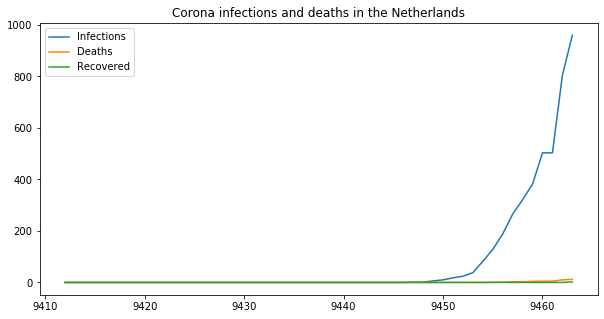

In [14]:
# plot the progression of infections and deaths
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 5)
data[data['country'] == "Netherlands"]['infections'].plot(ax=ax)
data[data['country'] == "Netherlands"]['deaths'].plot(ax=ax)
data[data['country'] == "Netherlands"]['recovered'].plot(ax=ax)
plt.title("Corona infections and deaths in the Netherlands")
plt.legend(['Infections', 'Deaths', 'Recovered'])

In [15]:
# identify the countries occurring in the hospital data
countries_bed = data_beds['country'].unique()
countries_bed, countries_bed.shape

(array(['Japan', 'South Korea', 'Russia', 'Germany', 'Austria', 'Hungary',
        'Czech Republic', 'Poland', 'Lithuania', 'France', 'Slovakia',
        'Belgium', 'Latvia', 'Hong Kong', 'Estonia', 'Luxembourg',
        'Switzerland', 'Slovenia', 'China', 'Greece', 'Australia',
        'Norway', 'Portugal', 'Netherlands', 'Finland', 'Italy', 'Iceland',
        'Israel', 'Spain', 'Ireland', 'Turkey', 'United States',
        'New Zealand', 'Denmark', 'United Kingdom (more)', 'Canada',
        'Sweden', 'Chile', 'Colombia', 'Mexico'], dtype=object),
 (40,))

In [16]:
# identify the countries occurring in the timeseries data
countries_all = data['country'].unique()
#countries_all, countries_all.shape

In [17]:
# compute the overlap between the two sets
countries = np.intersect1d(countries_all, countries_bed)
countries, countries.shape

(array(['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'China',
        'Colombia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
        'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy',
        'Japan', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico',
        'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal',
        'Russia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
        'Turkey'], dtype=object),
 (35,))

In [18]:
# drop countries not in 'countries' array
def drop_unneeded_countries(data, countries):
    data['country'] = data.country.apply(lambda x: np.nan if x not in countries else x)
    data['country'] = data['country'].dropna()
    
    return data

In [19]:
# remove unneeded countries from all data
data = drop_unneeded_countries(data, countries)

In [20]:
data_latlong = drop_unneeded_countries(data_latlong, countries)

In [21]:
# summarize lat long by mean for countries with multiple states/regions
data_latlong = data_latlong.groupby('country').mean().reset_index()

In [22]:
data_beds = drop_unneeded_countries(data_beds, countries)

In [23]:
data_age = drop_unneeded_countries(data_age, countries)

In [24]:
# remove added tokens from country names
data_pop['country'].head()

0            China[b]
1               India
2    United States[c]
3           Indonesia
4            Pakistan
Name: country, dtype: object

In [25]:
data_pop['country'] = data_pop['country'].str.replace(r'\[.\]', '').str.replace('\s\(.*\)', '')

In [26]:
data_pop = drop_unneeded_countries(data_pop, countries)

<h2> Merging stage <h2>

In [27]:
# merge all the data by country
data = pd.merge(data, data_latlong, on='country')

In [28]:
data = pd.merge(data, data_beds, on='country')

In [29]:
data = pd.merge(data, data_pop, on='country')

In [30]:
data = pd.merge(data, data_age, on='country')

In [31]:
data.head()

,country,date,infections,Lat_x,Long_x,deaths,recovered,Lat_y,Long_y,Rank_x,...,Occupancy (%)[2],"ICU-CCB beds/100,000 inhabitants",Rank_y,Population,% of worldpopulation,Date,Source,age 0 to 14 years[1],age 15 to 64 years[2],age over 65 years[3]
0,Japan,1/23/20,1,36.0,138.0,0,0,36.0,138.0,1,...,75.5,NaN,11,"126,010,000",1.62%,1 Feb 2020,Monthly provisional estimate[12],12.9 %,60.1 %,27.0 %
1,Japan,1/24/20,2,36.0,138.0,0,0,36.0,138.0,1,...,75.5,NaN,11,"126,010,000",1.62%,1 Feb 2020,Monthly provisional estimate[12],12.9 %,60.1 %,27.0 %
2,Japan,1/25/20,2,36.0,138.0,0,0,36.0,138.0,1,...,75.5,NaN,11,"126,010,000",1.62%,1 Feb 2020,Monthly provisional estimate[12],12.9 %,60.1 %,27.0 %
3,Japan,1/26/20,4,36.0,138.0,0,1,36.0,138.0,1,...,75.5,NaN,11,"126,010,000",1.62%,1 Feb 2020,Monthly provisional estimate[12],12.9 %,60.1 %,27.0 %
4,Japan,1/27/20,4,36.0,138.0,0,1,36.0,138.0,1,...,75.5,NaN,11,"126,010,000",1.62%,1 Feb 2020,Monthly provisional estimate[12],12.9 %,60.1 %,27.0 %


In [32]:
# drop columns without value
data.columns

Index(['country', 'date', 'infections', 'Lat_x', 'Long_x', 'deaths',
       'recovered', 'Lat_y', 'Long_y', 'Rank_x', 'Continent', '2013', '2014',
       '2015', '2016', '2017', 'Actual', 'Proportional (%)',
       'Occupancy (%)[2]', 'ICU-CCB beds/100,000 inhabitants', 'Rank_y',
       'Population', '% of worldpopulation', 'Date', 'Source',
       'age 0 to 14 years[1]', 'age 15 to 64 years[2]',
       'age over 65 years[3]'],
      dtype='object')

In [33]:
#data = data.drop(['GeoId', 'Actual', 'Proportional (%)', 'Rank_x', 'Rank_y', 'Date', 'Source'], axis=1)
data = data.drop(['Actual', 'Proportional (%)', 'Rank_x', 'Rank_y', 'Date', 'Source', 'Lat_y', 'Long_y'], axis=1)

In [34]:
data[data['country'] == "Netherlands"].head()

,country,date,infections,Lat_x,Long_x,deaths,recovered,Continent,2013,2014,2015,2016,2017,Occupancy (%)[2],"ICU-CCB beds/100,000 inhabitants",Population,% of worldpopulation,age 0 to 14 years[1],age 15 to 64 years[2],age over 65 years[3]
8216,Netherlands,1/23/20,0,52.1326,5.2913,0,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
8217,Netherlands,1/24/20,0,52.1326,5.2913,0,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
8218,Netherlands,1/25/20,0,52.1326,5.2913,0,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
8219,Netherlands,1/26/20,0,52.1326,5.2913,0,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
8220,Netherlands,1/27/20,0,52.1326,5.2913,0,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %


In [35]:
data[data['country'] == "Netherlands"].tail()

,country,date,infections,Lat_x,Long_x,deaths,recovered,Continent,2013,2014,2015,2016,2017,Occupancy (%)[2],"ICU-CCB beds/100,000 inhabitants",Population,% of worldpopulation,age 0 to 14 years[1],age 15 to 64 years[2],age over 65 years[3]
8263,Netherlands,3/10/20,382,52.1326,5.2913,4,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
8264,Netherlands,3/11/20,503,52.1326,5.2913,5,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
8265,Netherlands,3/12/20,503,52.1326,5.2913,5,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
8266,Netherlands,3/13/20,804,52.1326,5.2913,10,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
8267,Netherlands,3/14/20,959,52.1326,5.2913,12,2,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
